# Подготовка данных для ASR

## Импорты

In [1]:
import re

import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from torch.utils.data import Dataset

from dataset_all import IPS1ASRDataset
from utils import clean_text

## Датасеты

In [2]:
ips_dataset_train = IPS1ASRDataset('../tatar_tts/train/')
ips_dataset_valid = IPS1ASRDataset('../tatar_tts/valid/')

In [3]:
print(f'len(ips_dataset_train) = {len(ips_dataset_train)}')
print(f'len(ips_dataset_valid) = {len(ips_dataset_valid)}')

len(ips_dataset_train) = 73185
len(ips_dataset_valid) = 14253


In [4]:
ips_dataset_train.data[65]

{'text': '356.175.txt', 'audio': '356.175.wav'}

In [5]:
def from_dataset_to_df(dataset: Dataset) -> pd.DataFrame:
    data = []
    for index in range(len(dataset)):
        item = dataset.get_metadata(index)
        
        text = clean_text(item[2])
        item_dict = {
            'id': str(item[0].split('/')[-1][:-4]),
            'text': text,
            'len': len(text),
            'word_count': len(text.split())
        }
        data.append(item_dict)
    df = pd.DataFrame(data)
    del data
    return df

In [6]:
df_train = from_dataset_to_df(ips_dataset_train)
df_valid = from_dataset_to_df(ips_dataset_valid)

In [7]:
df_train.loc[0].info()

<class 'pandas.core.series.Series'>
Index: 4 entries, id to word_count
Series name: 0
Non-Null Count  Dtype 
--------------  ----- 
4 non-null      object
dtypes: object(1)
memory usage: 64.0+ bytes


In [8]:
df_train.head()

,id,text,len,word_count
0,433.318,караса аны җен шулай чакыра ди,30,6
1,348.39,без нең бер генә кораб та зарарланмый,37,7
2,402.165,чистартып көннән көн сәгатьтән сәгатькә көтә б...,55,7
3,418.88,ни өчен русьта агач архитектура өстенлек иткән,46,7
4,423.187,малайның уйлары шул урында өзелде,33,5


In [9]:
df_valid.head()

,id,text,len,word_count
0,282.311,бүген,5,1
1,20.2,ниһаять халисә үзен кулга алды плащын һәм шарф...,59,10
2,272.354,бөгелеп төшмәве,15,2
3,270.262,бар уңышка ирешкән командалар,29,4
4,276.116,ураза кешенең сәламәтлегенә зыян салса шулай у...,62,9


## Исследование данных

### Длина текста

#### value_counts

In [10]:
df_train['len'].value_counts()

len
42     1970
41     1961
38     1913
34     1853
40     1834
       ... 
153       1
140       1
152       1
129       1
159       1
Name: count, Length: 148, dtype: int64

In [11]:
df_train['word_count'].value_counts()

word_count
7     13737
6     13568
5     13226
4      7532
8      7349
9      4828
3      3563
1      3173
10     2092
2      1737
11     1152
12      752
13      180
14      112
15       73
16       38
18       27
17       26
19        7
20        4
21        3
28        2
22        2
23        1
24        1
Name: count, dtype: int64

#### Гистограммы

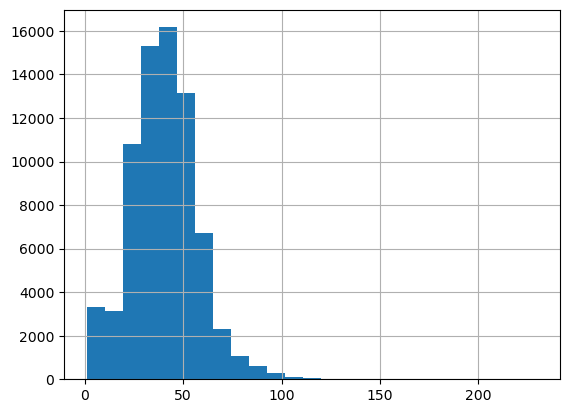

In [12]:
df_train['len'].hist(bins=25)
None

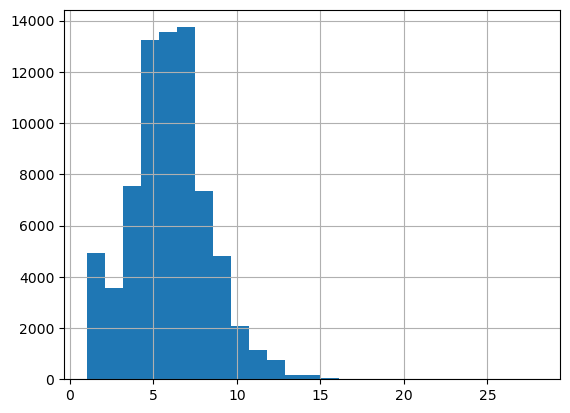

In [13]:
df_train['word_count'].hist(bins=25)
None

#### Ящик с усами

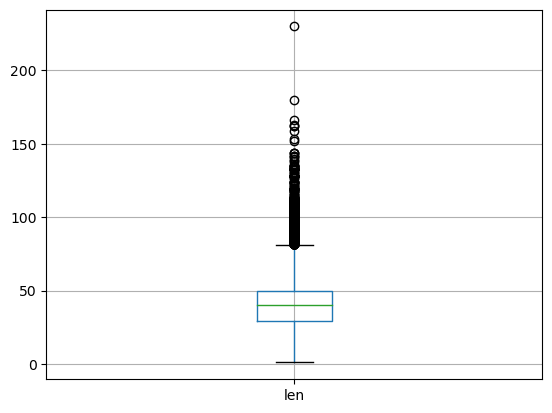

In [14]:
df_train.boxplot(column='len')
None

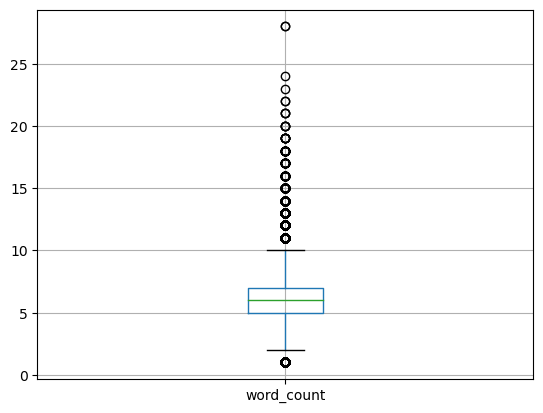

In [15]:
df_train.boxplot(column='word_count')
None

#### describe

In [16]:
df_train['word_count'].describe()

count    73185.000000
mean         6.052921
std          2.325373
min          1.000000
25%          5.000000
50%          6.000000
75%          7.000000
max         28.000000
Name: word_count, dtype: float64

### Вывод

In [17]:
df_train.loc[(2 < df_train['word_count']) & (df_train['word_count'] < 11)].shape[0] / df_train.shape[0] * 100

90.03894240623079

Удалим 10% данных, которые являются выбросами

In [17]:
#df_train = df_train.loc[(2 < df_train['word_count']) & (df_train['word_count'] < 11)]
#df_train = df_train.loc[df_train['word_count'] < 81]

#df_valid = df_valid.loc[(2 < df_valid['word_count']) & (df_valid['word_count'] < 11)]
#df_valid = df_valid.loc[df_valid['word_count'] < 81]

In [18]:
#df_train.to_csv('../tatar_tts/train.csv')
#df_valid.to_csv('../tatar_tts/valid.csv')

### Цифры

In [19]:
def get_digits(text):
    numbers = re.findall(r'\d+', text)
    return numbers == []

In [20]:
assert get_digits('бөгелеп төшмәве') == True, 'Неверная работа функции get_digits'
assert get_digits('бөгелеп төшмәве 1') == False, 'Неверная работа функции get_digits'
assert get_digits('1 бөгелеп төшмәве 2') == False, 'Неверная работа функции get_digits'

In [21]:
df_train['numbers'] = df_train['text'].apply(lambda row: get_digits(row))
df_valid['numbers'] = df_valid['text'].apply(lambda row: get_digits(row))

In [22]:
df_train.loc[df_train['numbers'] == False].head()

,id,text,len,word_count,numbers


In [23]:
df_valid.loc[df_valid['numbers'] == False].head()

,id,text,len,word_count,numbers


In [24]:
df_train.loc[df_train['numbers'] == False].shape[0]

0

Найдено 33 строки в тренировочном наборе данных, в которых встречаюся числительные

### Специальные символы

In [25]:
def get_char_dijits(text):
    special_characters = '@#$%^&*()-+_=<>/\'":;[]{}\\|~`!?,.'
    for char in text:
        if char in special_characters:
            return False
    return True

In [26]:
assert get_char_dijits('бөгелеп төшмәве') == True, 'Неверная работа функции get_digits'
assert get_char_dijits('бөгелеп төшмәве ""') == False, 'Неверная работа функции get_digits'
assert get_char_dijits('1 бөгелеп төшмәве ..\\||') == False, 'Неверная работа функции get_digits'

In [27]:
df_train['char_dijits'] = df_train['text'].apply(lambda row: get_char_dijits(row))
df_valid['char_dijits'] = df_valid['text'].apply(lambda row: get_char_dijits(row))

In [28]:
df_train.loc[df_train['char_dijits'] == False].head()

,id,text,len,word_count,numbers,char_dijits


In [29]:
df_train.loc[df_train['char_dijits'] == False].shape[0]

0

In [30]:
df_valid.loc[df_valid['char_dijits'] == False].head()

,id,text,len,word_count,numbers,char_dijits


In [31]:
df_valid.loc[df_train['char_dijits'] == False].shape[0]

0

Мы разрешаем иметь в данных !?, символы. остальные нужно будет удалить из датасета